In [5]:
#calcuration libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import csv
import os
import codecs
import time
import seaborn as sns

import scipy.stats

rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

fontsize_legend = 16 
linesize_legend = 4 
plt.rc('legend',fontsize=fontsize_legend)

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

In [6]:
# Material properties for Ethylen Glycol
A = 2.0148;
B = 4.50E-3;
def cp(T):
    cp = (A + B * (T+273.15));
    return cp
def cp_K(T):
    cp_K = A + B * (T);
    cp_K =  cp_K *1000;##???
    return cp_K
C = 0.2134;
D = 6.071E-4;
def Lambda(T):
    Lambda = C + D * (T+273.15);
    return Lambda
def Lambda_K(T):
    Lambda_K = C + D * (T);
    return Lambda_K
E = 1.1001E-4;
F = 325.85;
G = -207.30;
def mu(T):
    mu = E * np.exp( F / ( (T+273.15) + G) );
    return mu
def mu_K(T):
    mu_K = E * np.exp( F / ( (T) + G) );
    return mu_K
H = 1268.28;
I = -0.66;
def rho(T):
    rho = H + I * (T+273.15);
    return rho
def rho_K(T):
    rho_K = H + I * (T);
    return rho_K
def nu(T):
    nu = mu(T)/rho(T);
    return nu
def nu_K(T):
    nu_K = mu_K(T)/rho_K(T);
    return nu
def Pr(T):
    Pr = ( mu(T) * cp(T) * 1000 ) / Lambda(T);
    return Pr
def Pr_K(T):
    Pr_K = ( mu_K(T) * cp_K(T)) / Lambda_K(T);
    return Pr

# conduction equation for inner wall temperatuer 110-115
#Lambda_K = 0.16
DeltaK = 0.065E-3
Lambda_N = 20#!!!!!!!!!!!!!!!!!!!!!!!!
Lambda_C = 0.16 #thermal conductivity[W/mK] of capton tape
Lambda_iso = 0.055 #thermal conductivity[W/mK] of glass wool, outer isolation
riso = 0.05 #thickness of isolation
#temperature distribution in pipe(ri << r << ra)
def T1(r,qv,qzu,TN,Ta):
    T1 = (qzu/(2*Lambda_N)*ra**2)*(0.5-0.5*(r/ra)**2+np.log(r/ra)) + Ta - qv/Lambda_N*(ra+DeltaK)*(Lambda_N/Lambda_C*np.log(ra/(ra+DeltaK))+np.log(r/ra))
    return T1
#temperature distribution in capton tape(ra << r << ra+DeltaK)
def T2(r,qv,Ta):
    T2 = - qv/Lambda_C*(ra+DeltaK)*np.log(r/(ra+DeltaK)) + Ta
    return T2

def calculate_mean(data):
    s = sum(data)
    N = len(data)
    mean =s/N
    return mean

#平均からの偏差を求める
def find_difference(data):
    mean = calculate_mean(data)
    diff = []
    for num in data:
        diff.append(num-mean)
    return diff

def calculate_variance(data):
    diff = find_difference(data)
    #差の２乗を求める
    squared_diff = []
    for d in diff:
        squared_diff.append(d**2)
    #分散を求める
    sum_squared_diff = sum(squared_diff)
    variance = sum_squared_diff/len(data)
    return variance


#Experimental Facilities
di=12E-3
da=15E-3
ri = di/2
ra = da/2
disoa = 90E-3
L=2
V=(da**2-di**2)*np.pi/4*L
Ageo_MS = di*np.pi*L #円菅内部の試験部表面積
Ugeo_MS = di*np.pi #円菅内面積
Ageo_quer = di**2*np.pi/4

#PT100 position
#x_pos_TPt100_old = 
x_pos_TPt100_new =      [0.030, 2.400, 2.600, 2.800, 3.000, 3.000, 3.140, 5.500]
x_pos_TPt100_new_tmp =  [2.400, 2.600, 2.800, 3.000, 3.140]
TPT100_new_tmp =        [0,0,0,0,0]
xTin  = 0.03
xTout = 5.50
x_MS_in = 1.2
x_MS_out = 3.2

In [7]:
folder_names       = ['pr20_re4000/']
where = folder_names[0]
n_samples  = 0
for f_name in sorted(os.listdir(where)):
    n_samples = n_samples + 1
    number_of_stations = np.size(folder_names)
    Re_M_ave = np.zeros(number_of_stations)
    cf_M_ave = np.zeros(number_of_stations)
    Nu_M_ave = np.zeros(number_of_stations)
    Pr_w_ave = np.zeros(number_of_stations)
    Pr_m_ave = np.zeros(number_of_stations)
    T_m_ave = np.zeros(number_of_stations)
    T_w_ave = np.zeros(number_of_stations)
    dmu_ave = np.zeros(number_of_stations)
    drho_ave = np.zeros(number_of_stations)
    
    Re_m_samples = []
    cf_m_samples = []
    Nu_samples = []
    delta_NuMessung_samples = []


for j in range(0,number_of_stations):
    filename_list = []
    T_in_list = []
    T_out_list = []
    Tw_list = []
    Tm_list = []
    mdot_list = []
    qw_list = []
    Re_m_list = []
    Re_w_list = []
    ReTau_list = []
    Pr_m_list = []
    Pr_w_list = []
    NuMessung_list = []
    cf_M_list = []
    delta_NuMessung_list = []
    delta_cf_M_list = []
    df_list_all = []
    delta_p_list = []
    mu_m_list = []
    mu_w_list = []
    I_MS_list = []
    Nu_turb_Gni4Tau_list = []
    P_MS_list=[]
    
    # where = './data/'
    where = folder_names[j]
    # print[j]

    
    for fname in sorted(os.listdir(where)):
        filename = where + fname
        if filename == where + 'rubbish':
            continue
        elif filename == where + '.DS_Store':
            continue
        elif filename == where + '.DS_Store.txt':
            continue
        else:
            txt = codecs.open(filename, encoding ='cp1252')
            data = np.loadtxt(txt, skiprows = 1)
            Tsa = data[:,0] #Temperatur aussen: Ts_aussen / °C
            Tsi = data[:,1] #Temperatur innen: Ts innen / °C
            Ti = data[:,2] #Fluidtemperatur: T / °C
            m_dot_C1 = data[0,3] #Massenstrom: m_dot C1 / kg/h
            m_dot_C2 = data[0,4] #Massenstrom: m_dot C2 / kg/h
            Re_C1 = data[0,5] #Re C1 / -
            Re_C2 = data[0,6] #Re C2 / -
            v_C1 = data[0,7] #Geschwindigkeit: v C1 / m/s
            v_C2 = data[0,8] #Geschwindigkeit: v C2 / m/s
            U_MS = data[0,9] #Spannungsabfall Messstrecke: U_MS / V
            I_MS = data[0,10] #Strom Messstrecke: I_MS / A
            P_MS = data[0,11] #Leistung Messstrecke: P_MS / W
            q = data[0,12] #spzifische Leistung: q / W/m3
            P1 = data[0,13] #Druckmessung: P1 / Pa
            P2 = data[0,14] #Druckmessung: P2 / Pa
            dp = data[0,15] #Differenzdruck: dp / bar
            nu_Fluid = data[0,16] #kin. Viscositaet Fluid: nu / m2/s
            rho_Fluid = data[0,17] #Dichte Fluid: rho / kg/m3
            Lambda_Fluid = data[0,18] #Waermeleitfaehigkeit Fluid: lambda / W/mK
            cp_Fluid = data[0,19] #spez. Waermekapazitaet Fluid: cp /J/kgK
            Pr_Fluid = data[0,20] #Pr / -
            Lambda_Rohr = data[0,21] #Waermeleitfaehigkeit Rohr: lambda / W/mK
            Nu_Fluid = data[0,22] #Nu / -
            I1 = data[0,23] #Strom I / A
            U1 = data[0,24] #Spannung U / V
            dp_T1 = data[0,25] #Re_tau / - 関数名とtxtが合っていない？
            dp_T2 = data[0,26] #Re_tau_Pet / -　関数名とtxtが合っていない？
            dp_T3 = data[0,27] #dp Pet / Pa
            #Mittel (U*I) mean P / W
            Pm = data[0,28] #Mittel (U*I) mean P / W
            TPT100_a_old = data[:5,29]#PT100 T aussen(5 value)
            TPT100_i_old = data[:5,30]#PT100 T innen(5 value)
            TPT100_m_old = data[:5,31]#PT100 T mittel(5 value)
            TPT100_a_new = data[:8,38]#!!!!!!!!!!!!!
            TPT100_i_new = data[:8,39]
            TPT100_m_new = data[:8,40]
            NuPt100 = data[0,32] #Nu Pt100
            NuQm = data[0,33] #Nu Qm
            # zeta computation Einlesen
            ZRem100 = data[0,34] #zeta Re
            Zzeta100 = data[0,35] #zeta
            Zqm100 = data[0,36] #zeta qw
            TPT100_T5 = data[0,37] #PT100 T5
            TPT100_out = TPT100_a_new
            TPT100_in  = TPT100_i_new
            TPT100_mean= TPT100_m_new
            TPT100_new = TPT100_i_new
            Tm_aus = TPT100_new[7]
            Tm = Tm_aus
            n_samples  = n_samples  + 1
            
            # iteration to update the temperatuer dependent material properties --> new wall temperature 205-339
            # first loop doesnt include dq heat loss.
            for i in range(2):
                Tw = TPT100_new[6]
                T_iso = Ti[1]
                T_inf = Ti[6]
                Pr_w = Pr(Tw)
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                dqhldT = 1
                zeta_mischer = 32.46
                Thl = (Tw + Tm)*0.5
                qhl = dqhldT * (Thl - T_iso)
                qhlm2 = qhl / (da*np.pi*5.45)
                Re_m = Re_C1
                Lambda_Pet = (1.8*np.log10(Re_m)-1.5)**(-2)
                
                #Specific heat capasity, cp mean
                T_in = TPT100_new[0] + 273.15
                T_out = TPT100_new[7] + 273.15
                Ac = 2.0148
                Bc = 4.50E-3
                cpm = (Ac*(T_out-T_in)+Bc/2*(T_out**2-T_in**2))/(T_out-T_in)*1000 #Eq(2.108)
                Wmean = Re_m*nu_m/di #velocisty
                mdot = m_dot_C1/3600
                
                #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                #x_pos_TPt100_new_tmp[0] = x_pos_TPt100_new[1]
                #x_pos_TPt100_new_tmp[1] = x_pos_TPt100_new[2]
                #x_pos_TPt100_new_tmp[2] = x_pos_TPt100_new[3]
                #x_pos_TPt100_new_tmp[3] = 0.5 * (x_pos_TPt100_new[4] + x_pos_TPt100_new[5])
                #x_pos_TPt100_new_tmp[4] = x_pos_TPt100_new[6]
                TPT100_new_tmp[0] = TPT100_new[1]
                TPT100_new_tmp[1] = TPT100_new[2]
                TPT100_new_tmp[2] = TPT100_new[3]
                TPT100_new_tmp[3] = 0.5 * (TPT100_new[4] + TPT100_new[5])
                TPT100_new_tmp[4] = TPT100_new[6]
                fit = np.polyfit(x_pos_TPt100_new_tmp, TPT100_new_tmp,1)
                gradT_PT100 = fit[0]
                Q_Pt100 = gradT_PT100*mdot*cpm*L
                qUI = P_MS/Ageo_MS
                dqw2 = (Lambda_Pet*(5.45-2.92)/di + zeta_mischer) * rho_m * Wmean**2 /2 * Wmean * Ageo_quer - qhl*(5.45-2.53)/5.45
                
                Qin_out = mdot*cpm*(T_out-T_in)
                dQ = Qin_out-P_MS
                gradT = (Qin_out/L) / (mdot * cpm )
                dTm = dqw2/(mdot*cpm)
                SA_Tm = gradT*(x_MS_out-x_pos_TPt100_new[6])
                Tm_aus = TPT100_new[7] - dTm
                Tm = Tm_aus - SA_Tm
                
                qw = Qin_out/ Ageo_MS
                if(Qin_out>0):
                    qvA=qhlm2
                    #print('qvA=qhlm2')
                else:
                    qvA=0
                    #print('qvA=0')
                
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
                
                #P_spez_m2 = P_MS/A;
                P=Pm
                P=P_MS
                #Reynolds number[-]
                Re_m = m_dot_C1/3600.*4./(nu_m*rho_m*di*np.pi)
                Re_w = m_dot_C1/3600.*4./(nu_w*rho_m*di*np.pi)
                #Wall temperature calibration
                qVol = Qin_out / V
                Tw = T1(ri,qvA,qVol,TPT100_a_new[6], TPT100_a_new[6])
                Tw_SA6 = T1(ri,qvA,qVol, TPT100_a_new[5], TPT100_a_new[5])
                Tw_SA5 = T1(ri,qvA,qVol, TPT100_a_new[4], TPT100_a_new[4])
                Tw_SA4 = T1(ri,qvA,qVol, TPT100_a_new[3], TPT100_a_new[3])
                Tw_SA3 = T1(ri,qvA,qVol, TPT100_a_new[2], TPT100_a_new[2])
                Tw_SA2 = T1(ri,qvA,qVol, TPT100_a_new[1], TPT100_a_new[1])
                Tw_SA1 = T1(ri,qvA,qVol, TPT100_a_new[0], TPT100_a_new[0])
                Tw_SA8 = T1(ri,qvA,qVol, TPT100_a_new[7], TPT100_a_new[7])
                TPT100_new[6] = Tw
                TPT100_new[0] = Tw_SA1
                TPT100_new[1] = Tw_SA2
                TPT100_new[2] = Tw_SA3
                TPT100_new[3] = Tw_SA4
                TPT100_new[4] = Tw_SA5
                TPT100_new[5] = Tw_SA6
                TPT100_new[7] = Tw_SA8
                
                Nu_QmdotCpDt_w = qw * di / (Lambda_w * (Tw-Tm ))
                NuMessung = Nu_QmdotCpDt_w
                tau_w = dp*di/(1.*4.)
                
                ###ADDDDDDDDDDD!!!!!!!!!
                Pr_w     = Pr(Tw)
                rho_w    = rho(Tw)
                nu_w     = nu(Tw)
                mu_w     = nu_w * rho_w
                cp_w     = cp(Tw)
                Lambda_w = Lambda(Tw)
                Pr_m     = Pr(Tm)
                rho_m    = rho(Tm)
                nu_m     = nu(Tm)
                mu_m     = nu_m * rho_m
                cp_m     = cp(Tm)
                Lambda_m = Lambda(Tm)
            
                w_tau=(tau_w/rho_m)**(1./2.) #share velocity
                ReTau = w_tau*di/nu_w
                ###ADDDDDDDDDDD!!!!!!!!!
                Wmean = Re_m*nu_m/di
                cf_M = tau_w/(rho_m*Wmean**2./2.) #Friction coefficient Eq(4.8)
                
                #print(filename)
                #桁数は四捨五入ではなく、「丸め」であることに注意
                #print('Tin','{:.4f}'.format(T_in), 'Tout','{:.4f}'.format(T_out),'Tw', '{:.4f}'.format(Tw), 'Tm', '{:.4f}'.format(Tm))
                #print('mdot', '{:.5f}'.format(mdot))
                #print('qw', '{:.5e}'.format(qw))
                #print("Re[-]",'{:.5e}'.format(Re_m),'{:.4f}'.format(ReTau))
                #print('Pr[-]','{:.2f}'.format(Pr_m),'{:.2f}'.format(Pr_w))
                #print('Nu','{:.4f}'.format(NuMessung))
                #print('cf_M','{:.10f}'.format(cf_M))
        
        # Measurement uncertainty
        #### absolute error
        T_e = 0.04#New PT100??????????????
        #mass flow rate [kg / s]
        mdot_e = 0.20E-3 * mdot
        #pressure[Pa]
        p_e = 0.35E-3 * dp #dpでいいの???????????
        #density [kg / m^3]
        rho_e = 0.66 * T_e
        #specific heat capasity [J / kg K]
        cp_e = 4.5 * T_e
        #thermal conductivity of fluid [W / m K]
        Lambda_e = 6.071e-4 * T_e
        
        #Uncertainty in each measurement influencing
        delta_mdot = (mdot_e / mdot)**2.
        delta_cp = (cp_e/cp_m)**2. #cpm、cp_mどちら？
        delta_Lambda = (Lambda_e/Lambda_m)**2.
        delta_T = (T_e/(T_in-Tm))**2. + ((T_e * (T_in-Tw)) / ((T_in-Tm)*(Tm-Tw)))**2. + (T_e/(Tm-Tw) )**2#T_outは影響しない？
        #Measurement uncertainty for NuMessung
        delta_NuMessung = (delta_mdot + delta_cp + delta_Lambda + delta_T)**(1./2.) * NuMessung
        #Reduction of the uncertainty of the cp calibration is the most effective, in order to reduce the uncertainty of Nu.
        
        #Uncertainty in each measurement influencing
        delta_p = (p_e / dp)**2.
        delta_rho = (rho_e / rho_m)**2.
        #Measurement uncertainty for cf_M
        delta_cf_M = (delta_p + delta_rho + (2.*delta_mdot))**(1./2.) * cf_M
        #Reduction of the uncertainty of the p calibration is the most effective, in order to reduce the uncertainty of cf.
        
        xi_Pet4Tau = (1.8 * np.log10(Re_m) - 1.5)**(-2)#Petukhov
        Nu_turb_Gni4Tau = ((xi_Pet4Tau/8. * Re_m * Pr_m) / (1. + 12.7 * (xi_Pet4Tau/8)**0.5 * (Pr_m**(2./3.) - 1.))) *(Pr_m/Pr_w)**0.11
        Nu_turb_Gni4Tau_list.append(Nu_turb_Gni4Tau)

        
        #Nu_turb_Gni4Tau_list.append(Nu_turb_Gni4Tau)
        
        filename_list.append(filename)
        T_in_list.append(T_in)
        T_out_list.append(T_out)
        Tw_list.append(Tw)
        Tm_list.append(Tm)
        mdot_list.append(mdot)
        qw_list.append(qw)
        Re_m_list.append(Re_m)
        Re_w_list.append(Re_w)
        ReTau_list.append(ReTau)
        Pr_m_list.append(Pr_m)
        Pr_w_list.append(Pr_w)
        NuMessung_list.append(NuMessung)
        cf_M_list.append(cf_M)
        delta_NuMessung_list.append(delta_NuMessung)
        delta_cf_M_list.append(delta_cf_M) 
        
        mu_m_list.append(mu_m)
        mu_w_list.append(mu_w)
        delta_p_list.append(dp)
        
        I_MS_list.append(I_MS)
        P_MS_list.append(U_MS)
        
        
        epoch = os.path.getmtime(filename)
        filename_day = time.strftime('%d%m%Y', time.localtime(epoch))
        filename_time = time.strftime('%H%M%S', time.localtime(epoch))
        #https://tonari-it.com/python-file-get-time-epoch/#toc5
        
    # Pr_m_ave = sum(Pr_m_list)/len(Pr_m_list)
    # Pr_w_ave = sum(Pr_w_list)/len(Pr_w_list)
    mu_m_ave = sum(mu_m_list)/len(mu_m_list)
    mu_w_ave = sum(mu_w_list)/len(mu_w_list)
    #sum(Tm_list)/len(Tm_list)
    
    # print(len(Re_m_list))
    cf_M_ave[j] = sum(cf_M_list     )/len(cf_M_list)
    Re_M_ave[j] = sum(Re_m_list     )/len(Re_m_list)
    Nu_M_ave[j] = sum(NuMessung_list)/len(NuMessung_list)
    Pr_m_ave[j] = sum(Pr_m_list)/len(Pr_m_list)
    Pr_w_ave[j] = sum(Pr_w_list)/len(Pr_w_list)
    T_m_ave[j] = sum(Tm_list)/len(Tm_list)
    T_w_ave[j] = sum(Tw_list)/len(Tw_list)
    dmu_ave[j] = rho(T_m_ave[j])*nu(T_m_ave[j])  - rho(T_w_ave[j])*nu(T_w_ave[j]) 
    drho_ave[j] = rho(T_m_ave[j])  - rho(T_w_ave[j]) 
    if j == 0:
        Re_m_samples = Re_m_list
        cf_m_samples = cf_M_list
        Nu_samples   = NuMessung_list
        delta_NuMessung_samples = delta_NuMessung_list
    else: 
        Re_m_samples.extend(Re_m_list)
        cf_m_samples.extend(cf_M_list)
        Nu_samples.extend(NuMessung_list)
        delta_NuMessung_samples.extend(delta_NuMessung_list)

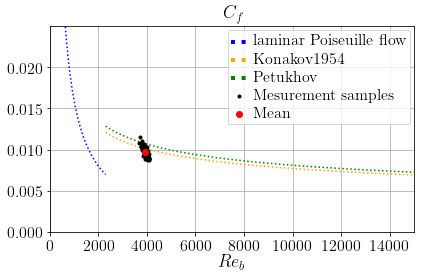

In [8]:
Re_lam = np.linspace(1,2300,)
Re_turb = np.linspace(2300,15000,)
#Skin friction for laminar flow
Cf_lam = 16 / Re_lam
#Skin friction for turbulent flow
Cf_Konakov =   0.25 * (1.8*np.log10(Re_turb) - 1.5)**(-2) #3000 < Re < 5*10^5, Eq(4.17) German literature!!!!
Cf_Petukhov =  0.25 * (1.8*np.log10(Re_turb) - 1.64)**(-2) #3000 < Re < 5*10^5, Eq(8.21) 違う！！！！

upRe = 15000
upCf = 0.025

fig = plt.figure(1)
ax1=plt.subplot(111) 
plt.xlim(100,15000)
plt.ylim(0.005,0.025)

plt.plot(Re_lam, Cf_lam, color='blue',linestyle="dotted", label='laminar Poiseuille flow')
plt.plot(Re_turb, Cf_Konakov, color='orange',linestyle="dotted", label="Konakov1954")
plt.plot(Re_turb, Cf_Petukhov, color='green',linestyle="dotted", label="Petukhov")

plt.errorbar(Re_m_samples, cf_m_samples, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement samples")
plt.errorbar(Re_M_ave, cf_M_ave, fmt='o', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label="Mean")

plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$C_{f}$' ,fontsize=fontsize_legend+2)


#plt.subplots_adjust(right=0.94)
#plt.subplots_adjust(bottom=0.06)
#plt.subplots_adjust(top=0.92)
#plt.subplots_adjust(wspace=0.0, hspace=0, right=.95)
ax1.xaxis.set_ticks(np.arange(0,upRe+1,2000))
ax1.yaxis.set_ticks(np.arange(0,upCf,0.005) )
leg = ax1.legend(loc='upper right',prop={'size': 8})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=linesize_legend)
plt.setp(leg_texts, fontsize=fontsize_legend)

OutPutFig = './recf_pr20.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [9]:
print(nu_m)
print(mu_m)
print(T_m_ave)
print(mu(T_m_ave))

2.8129065440592e-06
0.0029996955499572396
[32.8264417]
[0.00298925]


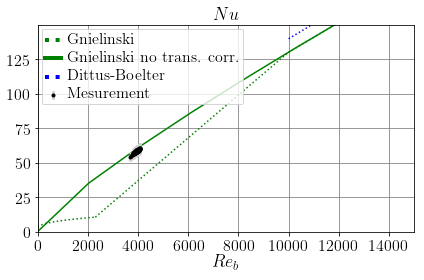

In [10]:
Pr_correlation = np.mean(Pr_w_ave)

fig = plt.figure(2)
ax1=plt.subplot(111) 
Re_lam = np.linspace(1.,2300.,)
Re_tran = np.linspace(2300.,10000.,)
Re_turb = np.linspace(10000.,100000.,)
Re_tot = np.linspace(1.,100000.,)
#laminar
Nu_lam1 = 3.66
Nu_lam2 = 0.7
Nu_lam3 = 1.615 * (Re_lam * Pr_correlation * di / L)**(1./3.)
Nu_lam = (Nu_lam1**3. + Nu_lam2**3. + Nu_lam3**3.)**(1./3.)
#turbulent
xi_Kon = (0.79 * np.log10(Re_turb) - 1.64)**(-2.)#Konakov
xi_Pet = (1.8 * np.log10(Re_turb) - 1.5)**(-2.)#Petukhov
Nu_turb_Pet = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) * (1. + (di/L)**(2./3.))
Nu_turb_Gni = ((xi_Pet/8. * Re_turb * Pr_correlation) / (1. + 12.7 * (xi_Pet/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

xi_Pet_no_corr = (1.8 * np.log10(Re_tot) - 1.5)**(-2.)
Nu_Gni_no_corr = ((xi_Pet_no_corr/8. * Re_tot * Pr_correlation) / (1. + 12.7 * (xi_Pet_no_corr/8.)**0.5 * (Pr_correlation**(2./3.) - 1.))) *(np.mean(Pr_m_ave)/np.mean(Pr_w_ave))**0.11

#transitional
c1 = Nu_lam[49]
c2 = Nu_turb_Gni[0]
r = (Re_tran - 2300.) / (10000. - 2300.)
Nu_tran = (1. - r) * c1 + r * c2

#Dittus_Boelter correlation
NuDB = 0.027*Re_turb**0.8 * Pr_correlation**0.4
#Entrance factor
entrance_section = 1.2
n = 2.08E-6 * Re_turb - 0.815
Nu_entrance = 1 + 23.99 * Re_turb **(-0.23) * (entrance_section / di)**n
#Roughness factor
epcylon = 3.2E-6 #assumed
Nu_roughness = 0.091 * (epcylon / di)**(-0.125) * Re_turb**(0.363*(epcylon/di)**0.1)
#Viscosity factor
Nu_viscosity = (mu_m_ave / mu_w_ave)**0.14
#Combining the four factors
Nu_Robinson = NuDB * Nu_entrance * Nu_roughness * Nu_viscosity

plt.xlim(1000,upRe)
plt.ylim(1,150)
#Emperical correlation
plt.plot(Re_lam, Nu_lam, color='green',linestyle="dotted", label="Gnielinski")
plt.plot(Re_tot, Nu_Gni_no_corr, color='green', label="Gnielinski no trans. corr.")
plt.plot(Re_tran, Nu_tran, color='green',linestyle="dotted")
plt.plot(Re_turb, Nu_turb_Gni, color='green',linestyle="dotted")
#plt.semilogx(Re_turb, Nu_turb_Pet, color='red',linestyle="dotted", label="Petukhov1958") Nu_Gni_no_corr
plt.plot(Re_turb, NuDB, color='blue',linestyle="dotted", label="Dittus-Boelter")

plt.errorbar(Re_m_samples, Nu_samples, delta_NuMessung_samples, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement")

leg = ax1.legend(loc='upper left',prop={'size': 8})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
# bulk-set the properties of all lines and texts
plt.setp(leg_lines, linewidth=linesize_legend)
plt.setp(leg_texts, fontsize=fontsize_legend)

plt.grid(True,color='gray', which="both", axis='both', ls="-")
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$Nu$' ,fontsize=fontsize_legend+2)
ax1.xaxis.set_ticks(np.arange(0,upRe+1,2000))
ax1.yaxis.set_ticks(np.arange(0 ,150,25))

OutPutFig = './renu_pr07.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

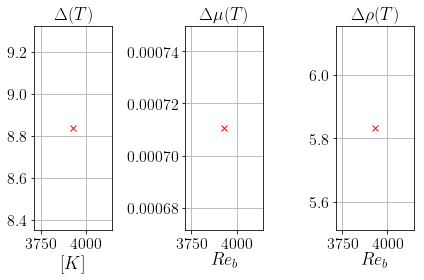

In [11]:
fig = plt.figure(3)
ax1=plt.subplot(131)
plt.plot(Re_M_ave, T_w_ave - T_m_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[K]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta{(T)}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(132) 
plt.plot(Re_M_ave, dmu_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$\Delta \mu{(T)}$' ,fontsize=fontsize_legend+2)

ax1=plt.subplot(133) 
plt.plot(Re_M_ave, drho_ave,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$\Delta \rho{(T)}$' ,fontsize=fontsize_legend+2)

OutPutFig = './deltaT.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

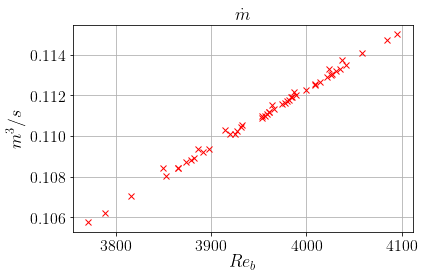

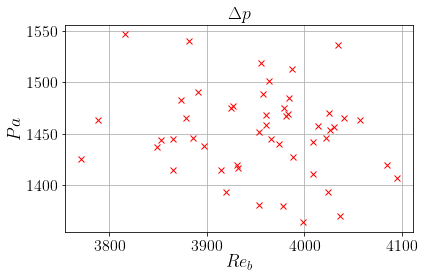

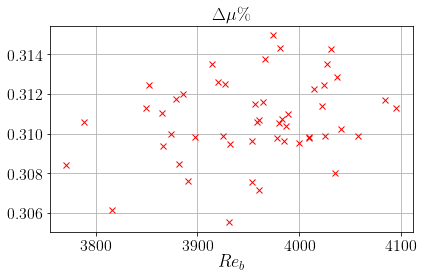

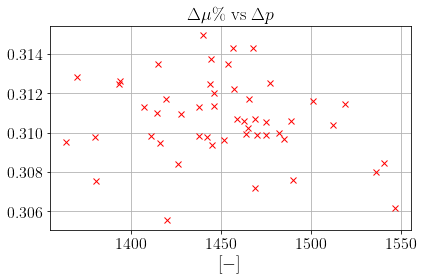

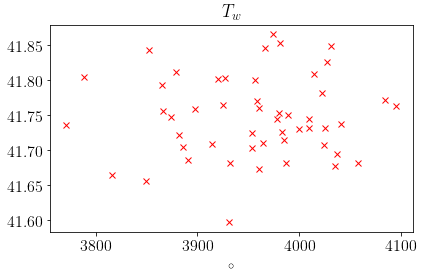

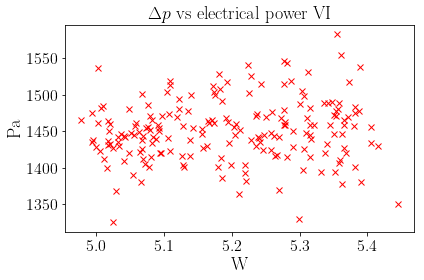

In [12]:
fig = plt.figure(4)
#ax1=plt.subplot(231) 
ax1=plt.subplot(111) 
plt.plot(Re_m_list[0:50], mdot_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$m^{3} / s$',fontsize=fontsize_legend+2)
plt.title (r'$ \dot{m}$' ,fontsize=fontsize_legend+2)
OutPutFig = './re_vs_massflow.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


fig = plt.figure(5)
ax1=plt.subplot(111) 
#ax1=plt.subplot(232) 
plt.plot(Re_m_list[0:50], delta_p_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.ylabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = './re_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


fig = plt.figure(6)
ax1=plt.subplot(111) 
#ax1=plt.subplot(233) 
plt.plot(Re_m_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50])  ,  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $' ,fontsize=fontsize_legend+2)
OutPutFig = './re_vs_mu.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


fig = plt.figure(7)
ax1=plt.subplot(111) 
#ax1=plt.subplot(234) 
plt.plot(delta_p_list[0:50], (np.asarray(mu_m_list[0:50]) - np.asarray(mu_w_list[0:50])) / np.asarray(mu_w_list[0:50]),  'rx')#, label=r'$\Delta \mu{T}$')
plt.grid(True)
plt.xlabel(r'$Pa$',fontsize=fontsize_legend+2)
plt.xlabel(r'$[-]$',fontsize=fontsize_legend+2)
plt.title (r'$ \Delta \mu \% $ vs $ \Delta p$' ,fontsize=fontsize_legend+2)
OutPutFig = './mu_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


fig = plt.figure(8)
ax1=plt.subplot(111) 
#ax1=plt.subplot(235) 
plt.plot(Re_m_list[0:50], Tw_list[0:50],  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'$Re_{b}$',fontsize=fontsize_legend+2)
plt.xlabel(r'$^{\circ}$',fontsize=fontsize_legend+2)
plt.title (r'$ T_{w}$' ,fontsize=fontsize_legend+2)
OutPutFig = './re_vs_Tw.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


fig = plt.figure(9)
ax1=plt.subplot(111) 
#ax1=plt.subplot(236) 
plt.plot(P_MS_list, delta_p_list,  'rx')#, label=r'$\Delta \mu{T}$')
plt.xlabel(r'W',fontsize=fontsize_legend+2)
plt.ylabel(r'Pa',fontsize=fontsize_legend+2)
plt.title (r'$\Delta p$  vs electrical power VI' ,fontsize=fontsize_legend+2)
OutPutFig = './ep_vs_pressure.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)


#Measurement 
#plt.errorbar(ReTau_list, NuMessung_list, fmt='.', color='black', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")
#plt.errorbar(ReTau_list, Nu_turb_Gni4Tau_list, fmt='.', color='red', ecolor='lightgray', elinewidth=3, capsize=1, label="Mesurement, Pr11.3")




#plt.subplots_adjust(right=0.94)
#plt.subplots_adjust(bottom=0.06)
#plt.subplots_adjust(top=0.92)
#plt.subplots_adjust(wspace=0.0, hspace=0, right=.95)

In [13]:

print('folders')
print(folder_names)
print('-------------')
print('Prm')
print(Pr_m_ave)
print('-------------')
print('Prw')
print(Pr_w_ave)

print(cf_M_ave)
#print(mu_m_ave)
variance = calculate_variance(cf_M_list)
std = variance**0.5
print(std)
#print(delta_cf_M_list)

folders
['pr20_re4000/']
-------------
Prm
[25.40015072]
-------------
Prw
[19.32848664]
[0.00969045]
0.00046637150566769233


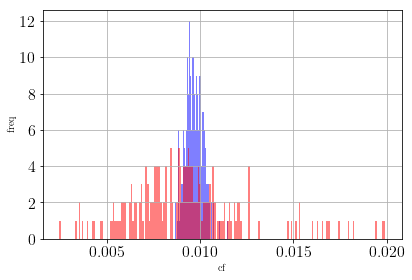

In [14]:
x = cf_M_list
low = [0.008126342097382343, 0.010002442418767783, 0.0075431755899352925, 0.009269101485606895, 0.005570234976929938, 0.010560290270804764, 0.00793547143103158, 0.010481604465531426, 0.0087682712669486, 0.011540685606053994, 0.008780978696594118, 0.00948509257311799, 0.019424040364336946, 0.009903811320089252, 0.009129045540119118, 0.007699008553429834, 0.009420388603429074, 0.00815478545825509, 0.011518710319985739, 0.007126704023624716, 0.01105548040498673, 0.00840874666448984, 0.010465484122285776, 0.008837974398505633, 0.005272233448474379, 0.0024395037616504627, 0.011223777708728669, 0.008510891950251634, 0.009279635578026817, 0.010424143595390473, 0.009295837400281703, 0.004195087674220314, 0.01082611213536226, 0.011106508500925, 0.0069147337421743395, 0.006502280066150754, 0.009121046809972595, 0.005689162944784722, 0.00785802359985119, 0.015289259538705472, 0.012581632030123713, 0.016848297186084382, 0.007550133977247425, 0.009953942202406326, 0.006367670002479778, 0.014892109951904731, 0.009060439450120358, 0.012178437750100692, 0.009958565100919215, 0.00969348829958109, 0.009388719823410588, 0.00722752074333073, 0.008958751391394034, 0.0033780905595622696, 0.009178445239242548, 0.007771023406923679, 0.00749445032589574, 0.009427075044714489, 0.005474481605225229, 0.01260208566317184, 0.010160648808857968, 0.011295838754613536, 0.007702013681385181, 0.005916592549854413, 0.007806435296017664, 0.005969828382552448, 0.007680777273226244, 0.010686829059462027, 0.008846015830382066, 0.017457722728324715, 0.003948570818633213, 0.007796905172016041, 0.00950919314295841, 0.007665278096008543, 0.011820613822464658, 0.009047532144575394, 0.006730932539523389, 0.003524478751461068, 0.007788740785791554, 0.009095870238181002, 0.011977332282517386, 0.009198526078471395, 0.009455756857150496, 0.005357589190804007, 0.006593256248835627, 0.004728232578141323, 0.009695447880784885, 0.01472774945788861, 0.006872752485324499, 0.009397625714069812, 0.007295123503529342, 0.007095069941112419, 0.006822024561641624, 0.011314671995187299, 0.007640429435064315, 0.00813284229007606, 0.01190201832834348, 0.008954181839902674, 0.01652767055010083, 0.008136945880699816, 0.008445566619646709, 0.009409905007641288, 0.006265358878540151, 0.007547427063371094, 0.009627845796213794, 0.0103752070788582, 0.010251045366888317, 0.01068539717271899, 0.010557957015664024, 0.009705894569425439, 0.0151657797506869, 0.007189951171066549, 0.012017811201094093, 0.009300992076934633, 0.005994337944691787, 0.006331957597264392, 0.012639748505736124, 0.010081636702156388, 0.012062249182911771, 0.008425525607308783, 0.009830290514207694, 0.012063791914451463, 0.013165977978808639, 0.010276127919826707, 0.006619091590254903, 0.007340022641530029, 0.009597820096937163, 0.006261080329077932, 0.006831713083616177, 0.00844334915403229, 0.007923305786807774, 0.005787974684411078, 0.019920461513358117, 0.009455842821137556, 0.010721072107032215, 0.005234260834517236, 0.016908566260928886, 0.0059153409663583985, 0.0042869626049087195, 0.004658145046669879, 0.010957934411668521, 0.01795097310425644, 0.009600861162582743, 0.009861075891990406, 0.005820655259712261, 0.010344202472602605, 0.007500128046589338, 0.005365226951745156, 0.016263849267954298, 0.008035247963547498, 0.012581460620369779, 0.008910097864695404, 0.010208638185541198, 0.0071107490949626675, 0.003707298206605219, 0.003529771736633614, 0.010755255799315133, 0.007667987707530014, 0.009548907240172655, 0.0067625363093234275, 0.008064313227161774, 0.009584768288753612, 0.011574190046507192, 0.005620879738834747, 0.010727713177945459, 0.0064374806920251305, 0.0064787982377580424, 0.009961270370669776, 0.00849739901168378, 0.007073897009504757, 0.008888767690978457, 0.00921271094220877, 0.008921962675975285, 0.011655086992818135, 0.007178542748730479, 0.01824551265245778, 0.006354761439279626, 0.008416298579865197, 0.015293090521146488, 0.007522405858385824, 0.008894569645420748, 0.009231317551500199, 0.009890478508105444, 0.009109650447482527, 0.01184510967986824, 0.0073782564105267625, 0.007760372421547064, 0.007996242955138773, 0.009891469880654251, 0.00889336076366287, 0.019774589225622183, 0.01606869312244686]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.hist(x, bins=50, color= 'blue',alpha=.5)
plt.hist(low, bins=200, color='red',alpha=.5)
#ax.set_title('histgram')
ax.set_xlabel('cf')
ax.set_ylabel('freq')

#plt.xlim(0,0.020)
#plt.ylim(0,15)

ax.grid(True)
OutPutFig = './histgram.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [15]:
len(cf_M_list)

195

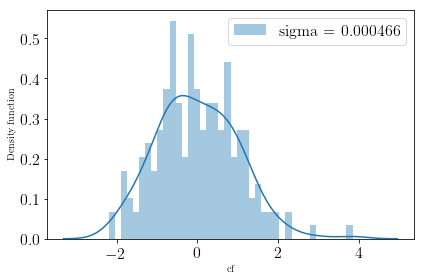

In [16]:
#Ref:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
sns.distplot((cf_M_list-np.mean(cf_M_list))/np.std(cf_M_list), hist=True, kde=True, rug=False, bins=40, label='sigma = 0.000466')
#sns.distplot(cf_M_list, hist=True, kde=True, rug=False, bins=40)
plt.legend()
plt.xlabel('cf')
plt.ylabel('Density function')
#plt.title('Side-by-Side Histogram with Multiple Airlines')
np.std(cf_M_list)
OutPutFig = './sigma.pdf'
plt.tight_layout()
plt.savefig(OutPutFig)

In [ ]:
len(cf_M_list)